In [22]:
import pandas as pd
import shap
from xgboost.sklearn import XGBClassifier

### The Dataset

In [23]:
df = pd.read_csv("data/bank-additional/bank-additional-full.csv", sep=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [24]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

The dataset is imbalanced, we will need to keep that in mind when building our models!

In [25]:
# Get X, y
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)

Let's look at the features in the X matrix:

Note the comment about `duration` feature. We will exclude it from our analysis.

In [26]:
X.drop("duration", inplace=True, axis=1)

In [27]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [28]:
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

We'll define a new `ColumnTransformer` object (new in sklearn 0.20) that keeps our numerical features and apply one hot encoding on our categorical features. That will allow us to create a clean pipeline that includes both features engineering (one hot encoding here) and training the model (a nice way to avoid data leakage)

In [29]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])


Now we can define our 4 models as sklearn `Pipeline` object, containing our preprocessing step and training of one given algorithm.

In [30]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])


Let's split the data into training and test sets.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)
y_train

7309     0
4169     0
35810    0
9668     0
34389    1
        ..
27855    1
7494     0
10747    0
34138    0
10241    0
Name: y, Length: 28831, dtype: int64

We're good to go!

### LA PARTE DEL TRAINING :

In [32]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [5, 10], 'model__min_child_weight': [5, 10], 'model__n_estimators': [25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score.

In [33]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.9002115778155457


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))])

Generate predictions

In [34]:
y_pred = xgb_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [35]:
accuracy_score(y_test, y_pred)

0.9014323865015781

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.71      0.21      0.32      1392

   micro avg       0.90      0.90      0.90     12357
   macro avg       0.81      0.60      0.64     12357
weighted avg       0.89      0.90      0.88     12357



In [38]:
reprocessor = lr_model.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
all_features = num_features + new_ohe_features

## SHAP

In [40]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [41]:
sample_100 = xgb_model.named_steps["preprocessor"].transform(X_train.sample(100, random_state=42))
shap_values = explainer.shap_values(sample_100)

In [42]:
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=sample_100[i], feature_names=all_features)

In [43]:
shap.force_plot(explainer.expected_value, shap_values,
             features=sample_100, feature_names=all_features)

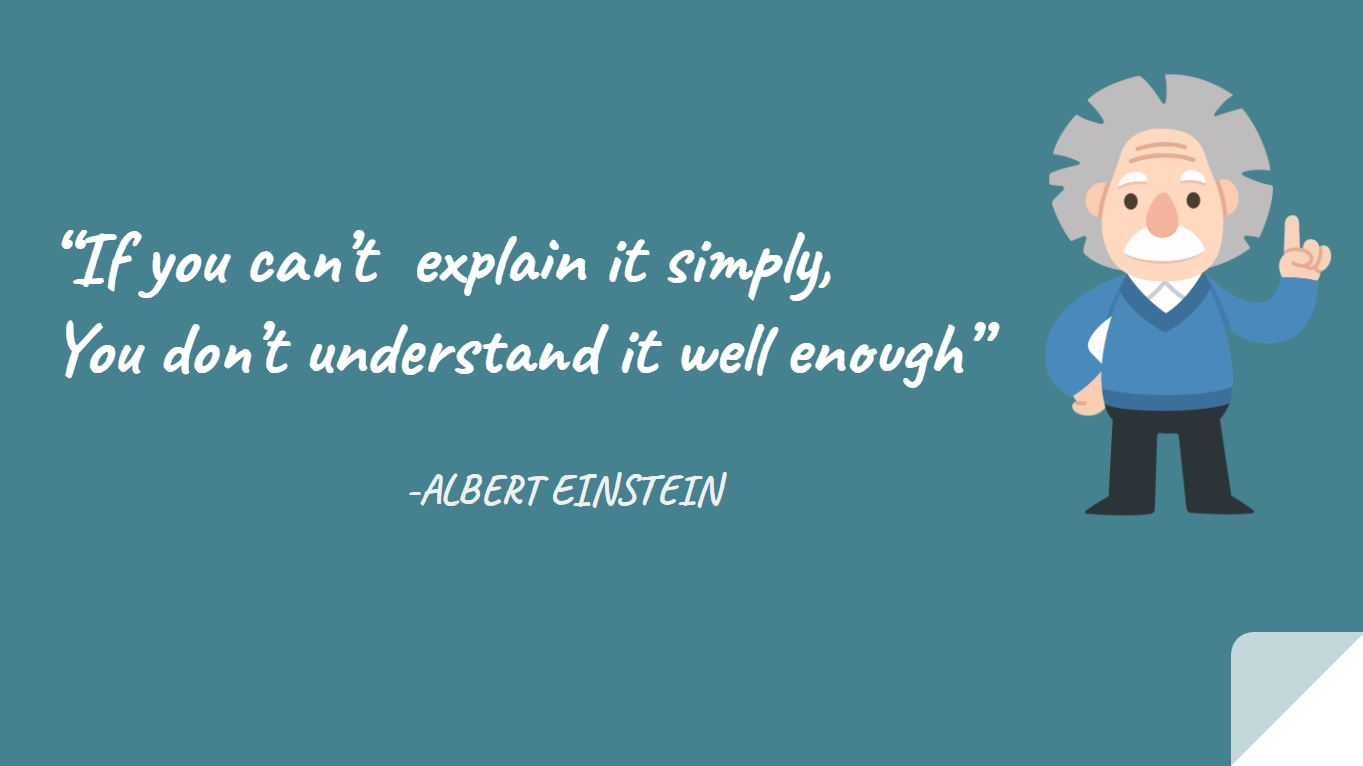

In [63]:
from IPython.display import Image
Image(filename = "/Users/hamza/Desktop/model interpretability/cit1.jpg", width=720, height=608)